In [1]:
from IPython.core.display import HTML, display
display(HTML('<style>.container { width:100%; !important } </style>'))

# Character Recognition

In [2]:
import numpy as np

The function $\texttt{vectorized_result}(d)$ converts the digit $d \in \{0,\cdots,9\}$ and returns a NumPy vector $\texttt{x}$ of shape $(10, 1)$ such that
$$
\texttt{x}[i] = 
\left\{
  \begin{array}{ll}
     1 & \mbox{if $i = j$;} \\
     0 & \mbox{otherwise.}
  \end{array}  
\right.
$$
This function is used to convert a digit $d$ into the expected output of a neural network that has an output unit for every digit.

In [3]:
def vectorized_result(j):
    e = np.zeros((10, 1), dtype=np.float32)
    e[j] = 1.0
    return e

In [4]:
vectorized_result(2)

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

The data that we are using is stored as a gzipped, 
<a href="https://docs.python.org/3/library/pickle.html">pickled</a> file.  Therefore, we need to import the corresponding libraries. 

In [5]:
import pickle
import gzip

The function $\texttt{load_data}()$ returns a tuple of the form
$$ (\texttt{training_data}, \texttt{validation_data}, \texttt{test_data}) $$
where 
<ul>
<li> $\texttt{training_data}$ is a list containing 50,000 pairs $(x, y)$ s.t.  
     $\textbf{x}$ is a 784-dimensional `numpy.ndarray` containing the input image and
     $\textbf{y}$ is a 10-dimensional `numpy.ndarray` corresponding to the correct digit for x.</li>
<li> $\texttt{validation_data}$ and</li>
<li> $\texttt{test_data}$ are lists containing 10,000 pairs $(\textbf{x}, y)$.  In each case, 
     $\textbf{x}$ is a 784-dimensional `numpy.ndarry` containing the input image, 
     and $y$ is the corresponding digit value.
</ul>
Note that the formats for training data and validation data are different.

In [6]:
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train, validate, test = pickle.load(f, encoding="latin1")
    training_inputs   = [np.reshape(x, (784, 1)) for x in train[0]]
    training_results  = [vectorized_result(y) for y in train[1]]
    training_data     = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in validate[0]]
    validation_data   = zip(validation_inputs, validate[1])
    test_inputs       = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data         = zip(test_inputs, test[1])
    training_data     = list(training_data)
    validation_data   = list(validation_data)
    test_data         = list(test_data)
    return (training_data, validation_data, test_data)

We store the data in three variables `training_data`, 

In [7]:
(training_data, validation_data, test_data) = load_data()

In oder to be able to view the images, we use the module `matplotlib`.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

The function $\texttt{show_digit}(\texttt{row}, \texttt{columns}, \texttt{offset})$ 
shows $\texttt{row} \cdot \texttt{columns}$ images of the training data.  The first image shown is the image at index $\texttt{offset}$.

In [9]:
def show_digits(rows, columns, offset=0):
    f, axarr = plt.subplots(rows, columns)
    for r in range(rows):
        for c in range(columns):
            i     = r * columns + c + offset
            image = 1 - training_data[i][0]
            image = np.reshape(image, (28, 28))
            axarr[r, c].imshow(image, cmap="gray")
            axarr[r, c].axis('off')
    plt.savefig("digits.pdf")    
    plt.show()

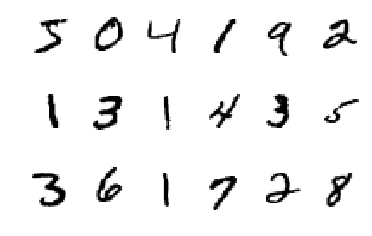

In [10]:
show_digits(3, 6)

Our goal is to find the weight matrices for a neural net that is able to recognize digits.  We initialize these weight matrices randomly. The function $\texttt{rndMatrix}(\texttt{rows}, \texttt{cols})$ returns a matrix of shape $(\texttt{rows}, \texttt{cols})$ that is filled with random numbers that have a Gaussian distribution with mean $0$ and variance $\displaystyle\frac{1}{\texttt{rows}}$.

In [11]:
def rndMatrix(rows, cols):
    return np.random.randn(rows, cols) / np.sqrt(cols)

In [12]:
rndMatrix(2, 2)

array([[-0.15090804,  0.69328733],
       [-1.54436881,  0.8727093 ]])

The function $\texttt{sigmoid}(x)$ computes the sigmoid of $x$, which is defined as
$$ \texttt{sigmoid}(x) = S(x) := \frac{1}{1 + \texttt{exp}(-x)}. $$ 
Since we are using NumPy to compute the exponential function, this function also works when $x$ is a vector.

In [13]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [14]:
sigmoid(np.array([-1, 0, 1]))

array([0.26894142, 0.5       , 0.73105858])

The function $\texttt{sigmoid_prime}(x)$ computes the derivative of the sigmoid function for $x$.  The implementation is based on the equation:
$$ S'(x) = S(x) \cdot \bigl(1 - S(x)\bigr) $$
$x$ can either be a number or a vector.

In [15]:
def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

In [16]:
sigmoid_prime(np.array([-5, 0, 5]))

array([0.00664806, 0.25      , 0.00664806])

In [17]:
import random

The class `Network` is used to represent a feedforward neural network with one hidden layer.
The constructor is called with the argument $\texttt{hiddenSize}$.  This parameter specifies the number of neurons in the hidden layer.  The network has $28 \cdot 28 = 784$ input nodes.  Each of the input nodes corresponds to the gray value of a single pixel in a $28 \cdot 28$ gray scale image of the digit that is to be recognized.  The number of output neurons is 10.  For $i \in \{0,\cdots,9\}$, the $i$th output neuron tries to recognize the digit $i$.

In [18]:
class Network(object):
    def __init__(self, hiddenSize):
        self.mInputSize  = 28 * 28
        self.mHiddenSize = hiddenSize
        self.mOutputSize = 10
        self.mBiasesH    = np.zeros((self.mHiddenSize, 1))   # biases hidden layer
        self.mBiasesO    = np.zeros((self.mOutputSize, 1))   # biases output layer
        self.mWeightsH   = rndMatrix(self.mHiddenSize, self.mInputSize)  # weights hidden layer
        self.mWeightsO   = rndMatrix(self.mOutputSize, self.mHiddenSize) # weights output layer

Given a neural network $n$ and an input vector $x$ for this neural network, the function $n.\texttt{feedforward}(x)$ compute the output of the neural network.

In [19]:
def feedforward(self, x):
    AH = sigmoid(self.mWeightsH @ x  + self.mBiasesH) # hidden layer
    AO = sigmoid(self.mWeightsO @ AH + self.mBiasesO) # output layer
    return AO

Network.feedforward = feedforward

Given a neural network $n$, the method $\texttt{sgd}(\texttt{training_data}, \texttt{epochs}, \texttt{mbs}, \texttt{eta}, \texttt{test_data})$ uses stochastic gradient descent to train the network.  The parameters are as follows:
<ul>
<li> $\texttt{training_data}$ is a list of tuples of the form $(x, y)$ where $x$ is an 
     input of the neural net and $y$ is a vector of length 10 representing the desired output. </li>
<li> $\texttt{epochs}$ is the number of epochs to train,</li>
<li> $\texttt{mbs}$ is the size of the minibatches,</li>
<li> $\texttt{eta}$ is the learning rate</li>
<li> $\texttt{test_data}$ is a list of tuples of the form $(x, y)$ where $x$ is an 
     input and $y$ is the desired output digit. 
</ul>    

In [20]:
def sgd(self, training_data, epochs, mbs, eta, test_data):
    n_test = len(test_data)
    n      = len(training_data)
    for j in range(epochs):
        random.shuffle(training_data)
        mini_batches = [training_data[k : k+mbs] for k in range(0, n, mbs)]
        for mini_batch in mini_batches:
            self.update_mini_batch(mini_batch, eta)    
        print('Epoch %2d: %d / %d' % (j, self.evaluate(test_data), n_test))
        
Network.sgd = sgd

In [21]:
def update_mini_batch(self, mini_batch, eta):
    nabla_BH = np.zeros((self.mHiddenSize, 1))  # gradient of biases  of hidden layer
    nabla_BO = np.zeros((self.mOutputSize, 1))  # gradient of biases  of output layer
    nabla_WH = np.zeros((self.mHiddenSize, self.mInputSize))  # gradient of weights of hidden layer
    nabla_WO = np.zeros((self.mOutputSize, self.mHiddenSize)) # gradient of weights of output layer
    for x, y in mini_batch:
        dltNbl_BH, dltNbl_BO, dltNbl_WH, dltNbl_WO = self.backprop(x, y)
        nabla_BH += dltNbl_BH
        nabla_BO += dltNbl_BO
        nabla_WH += dltNbl_WH
        nabla_WO += dltNbl_WO      
    alpha = eta / len(mini_batch)
    self.mBiasesH  -= alpha * nabla_BH
    self.mBiasesO  -= alpha * nabla_BO
    self.mWeightsH -= alpha * nabla_WH
    self.mWeightsO -= alpha * nabla_WO

Network.update_mini_batch = update_mini_batch

Given a neural network $n$, the method $n.\texttt{backprop}(x, y)$ takes a training example $(x,y)$ and calculates the gradient of the cost function with respect to this training example.

In [22]:
def backprop(self, x, y):
    # feedforward pass
    ZH = self.mWeightsH @ x  + self.mBiasesH
    AH = sigmoid(ZH)
    ZO = self.mWeightsO @ AH + self.mBiasesO
    AO = sigmoid(ZO)
    # backwards pass, output layer
    epsilonO = (AO - y) # * sigmoid_prime(ZO)
    nabla_BO = epsilonO
    nabla_WO = epsilonO @ AH.transpose()
    # backwards pass, hidden layer
    epsilonH = (self.mWeightsO.transpose() @ epsilonO) * sigmoid_prime(ZH)
    nabla_BH = epsilonH
    nabla_WH = epsilonH @ x.transpose()
    return (nabla_BH, nabla_BO, nabla_WH, nabla_WO)

Network.backprop = backprop

Given a neural network $n$, the method $n.\texttt{evaluate}(\texttt{test_data})$ uses the test data to compute  the number of examples that are predicted correctly by the neural network $N$.

In [23]:
def evaluate(self, test_data):
    test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
    return sum(int(y1 == y2) for (y1, y2) in test_results)

Network.evaluate = evaluate

In [24]:
%%time
net = Network(60)
net.sgd(training_data, 30, 20, 0.3, test_data)

Epoch  0: 9387 / 10000
Epoch  1: 9514 / 10000
Epoch  2: 9606 / 10000
Epoch  3: 9643 / 10000
Epoch  4: 9664 / 10000
Epoch  5: 9681 / 10000
Epoch  6: 9696 / 10000
Epoch  7: 9691 / 10000
Epoch  8: 9720 / 10000
Epoch  9: 9722 / 10000
Epoch 10: 9723 / 10000
Epoch 11: 9724 / 10000
Epoch 12: 9725 / 10000
Epoch 13: 9732 / 10000
Epoch 14: 9727 / 10000
Epoch 15: 9734 / 10000
Epoch 16: 9719 / 10000
Epoch 17: 9712 / 10000
Epoch 18: 9733 / 10000
Epoch 19: 9740 / 10000
Epoch 20: 9734 / 10000
Epoch 21: 9740 / 10000
Epoch 22: 9730 / 10000
Epoch 23: 9738 / 10000
Epoch 24: 9736 / 10000
Epoch 25: 9724 / 10000
Epoch 26: 9728 / 10000
Epoch 27: 9737 / 10000
Epoch 28: 9730 / 10000
Epoch 29: 9727 / 10000
CPU times: user 9min 19s, sys: 4.17 s, total: 9min 23s
Wall time: 2min 22s
